<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/68_Pro_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D0%BB%D0%BE%D1%81%D0%BE%D0%B2%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

Меняя параметры/гиперпараметры модели и подход к формированию выборки, добейтесь максимальной точности сетки.

*Теоретический материал:* https://youtu.be/RZr2WiaXWj4

# **Import библиотек**

*Разбор данного раздела:* https://youtu.be/yn_SN_a6jFE?t=944




In [ ]:
import numpy as np # библиотека для работы с массивами данных
from matplotlib import pyplot as plt # интерфейс для построения графиков простых функций
from IPython.display import Audio # загружаем модуль чтобы обратиться к HTML для записи аудио с микрофона в ноутбуке
from google.colab import files # модуль для загрузки файлов
import librosa # для параметризации аудио
import os # модуль для работы с операционной системой(воспользуемся методами работы с каталогами)
from sklearn.model_selection import train_test_split # модуль для разбивки данных на обучающую и тестовую выборки
from tensorflow.keras.utils import to_categorical # загружаем утилиты кераса для one hot кодировки
from tqdm import tqdm # быстрый, удобный progress bar для Python
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta # загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.models import Sequential # последовательная модель нейросети кераса
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape # загружаем необходимые слои для нейросети
import IPython.display as ipd # Воспроизведение звуковыйх файлов

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


# Объявление функций

*Разбор данного раздела:* https://youtu.be/yn_SN_a6jFE?t=997


In [ ]:
# Зададим параметры данных, к-е пойдут на вход нейросети
# DATA_PATH = "/content/drive/My Drive/Занятия/Майский курс/Занятие #26. Распознавание речи/comands/" # зададим путь к папке с аудиофайлами
# DATA_PATH_TEST = "/content/drive/My Drive/Занятия/Майский курс/Занятие #26. Распознавание речи/test_speech/" # Зададим пусть к файлу с тестовыми 30секнудными аудиофайлами
DATA_PATH = '/content/drive/MyDrive/Базы/Распознавание_речи/comands/'
DATA_PATH_TEST = '/content/drive/MyDrive/Базы/Распознавание_речи/test_speech/'

sample_rate = 22050 # Значение sample_rate аудиофайлов
feature_dim_1 = 20 # стандартная величина MFCC признаков
feature_dim_2 = int(.5 * sample_rate) # установленная длина фреймов (в секундах 0.5 = 500 мс)
step_mfcc = int(.02 * sample_rate) # Шаг смещения при разборе mfcc (в секундах 0.1 = 100мс)
channel = 1 # количество каналов
n_classes = 4 # Количество классов команд
classes = ['КОНДИЦИОНЕР', 'СВЕТ', 'ТЕЛЕВИЗОР'] # Классы команд (без фона)


In [ ]:
'''
Зададим функцию извлечения лейблов классов и их обработки
  Параметры:
    path - путь к папке, в которой находятся каталоги с обучающими командами    
'''

def get_labels(path=DATA_PATH): 
  labels = sorted(os.listdir(path)) # запишем лейблы классов по названию папок с данными - ['кондиционер', 'телевизор', 'свет', 'фон']  
  label_indices = np.arange(0, len(labels)) # запишем лейблы в виде индексов - [0, 1, 2, 3]
  return labels, label_indices, to_categorical(label_indices) # функция вернёт лейблы, индексы лейблов и их one-hot представление[0, 1, 0, 0]

In [ ]:
l,_,_ = get_labels()
l

['1_cond', '2_light', '3_tv', '4_noise']

In [ ]:
'''
Создаем функцию параметризации аудио(wav в мел-частоты)
  Параметры:
    length - длинна отрезков, на которые разбиваем исходный файл
    step - шаг, на который смещаем разбиение отрезка
'''

def wav2mfcc(file_path, length = 11025, step = 2205): 
  out_mfcc = [] # Выходной массив, содержащий mfcc исходного файла с шагом step
  out_audio = [] # Выходной массив, содеражищий аудиоинформацию исходного файла с шагом step
  y, sr = librosa.load(file_path) # Загружаем данные исходного файла  

  while (len(y)>=length):  # Проходим весь массив y, пока оставшийся кусочек не станет меньше указанной в параметре max_len длинны
    section = y[:length] # Берем начальный кусок длинной length
    section = np.array(section) # Переводим в numpy
    out_mfcc.append(librosa.feature.mfcc(section, sr)) # Добавляем в выходной массив out_mfcc значение mfcc текущего куска
    out_audio.append(section) # Добавляем в выходной массив аудио текущий кусок
    y = y[step:]  # Уменьшаем y на step
    
  out_mfcc = np.array(out_mfcc) # Преобразуем в numpy
  out_audio = np.array (out_audio) # Преобразуем в numpy
  return out_mfcc, out_audio # функция вернет массив мэл-частот и массив аудио-отрезков

In [ ]:
# '''
# Объявим функцию формирования и сохранения векторов данных, полученных для каждого набора аудио-команд в датасете
#   Параметры:
#     path  - путь к папке, в которой находятся каталоги с обучающими командами    
#     length - длинна отрезков, на которые разбиваем исходный файл
# '''

# def save_data_to_array(path=DATA_PATH, length=11025):
#   labels, _, _ = get_labels(path) # запишем лейблы классов
#   for label in labels: # для каждого лейбла
#     mfcc_vectors = [] # здесь соберем векторы MFCC частот
#     # извлечем для каждого файла его путь c названием папки и именем файла и соберём в список
#     # ['/content/drive/My Drive/Речевые команды/свет/recording12.wav', '/content/drive/My Drive/Речевые команды/свет/recording11.wav'..]
#     wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
#     for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)): # для каждого файла
      
#       mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc) # получим мел-частоты      
#       if (mfcc.shape[0] != 0 ): # Если массив не нулевой длинны
#         mfcc_vectors.extend(mfcc) # и добавим вектор в список для соответствующего класса
#     np.save(label + '.npy', mfcc_vectors) # сохраним массивы данных для каждого класса
#     print("В '{}' классе ".format(label), len(mfcc_vectors), "элементов") # выведем статистику по количеству элементов в классе

In [ ]:
'''
Объявим функцию формирования и сохранения векторов данных, полученных для каждого набора аудио-команд в датасете
  Параметры:
    path  - путь к папке, в которой находятся каталоги с обучающими командами    
    length - длинна отрезков, на которые разбиваем исходный файл
'''

def save_data_to_array(path=DATA_PATH, length=11025):
  labels, _, _ = get_labels(path) # запишем лейблы классов
  for label in labels: # для каждого лейбла
    mfcc_vectors = [] # здесь соберем векторы MFCC частот
    # извлечем для каждого файла его путь c названием папки и именем файла и соберём в список
    # ['/content/drive/My Drive/Речевые команды/свет/recording12.wav', '/content/drive/My Drive/Речевые команды/свет/recording11.wav'..]
    wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    for wavfile in tqdm(wavfiles, "Сохраняем векторы класса - '{}'".format(label)): # для каждого файла
      
      mfcc, _ = wav2mfcc(wavfile, length=length, step = step_mfcc) # получим мел-частоты      
      if (mfcc.shape[0] != 0 ): # Если массив не нулевой длинны
        mfcc_vectors.extend(mfcc) # и добавим вектор в список для соответствующего класса
    mfcc_vectors = mfcc_vectors[:1970] # ограничим массив с mfcc векторами до 1970 элеметов для каждого класса 
                                       # (1970 - набор признаков в минимальном классе, это значение дал предварительный запуск функции save_data_to_array )
    np.save(label + '.npy', mfcc_vectors) # сохраним массивы данных для каждого класса
    print("В '{}' классе ".format(label), len(mfcc_vectors), "элементов") # выведем статистику по количеству элементов в каждом классе

In [ ]:
'''
Создадим функцию для получения обучающей/проверочной выборки
  Параметры (необязательные):
    split_ratio - (1-split_ratio) равно доле тестовых образцов, которые вернет функция train_test_split
    random_state - начальное число, используемое генератором случайных чисел в финкции train_test_split
'''

def get_train_test(split_ratio=0.7, random_state=42, colab = True):
  labels, indices, _ = get_labels(DATA_PATH) # извлекаем имена и индексы лейблов классов

  # Getting first arrays
  X = np.load('/content/drive/MyDrive/Базы/Распознавание_речи/numpy/'+labels[0] + '.npy') # берем набор векторов для первого класса    
  y = np.zeros(X.shape[0], dtype = 'int32') # устанавливаем размер соответствующего ему лейбла
  

  # Объединяем в единый датасет в виде np-массива обучающий и проверочный набор данных
  for i, label in enumerate(labels[1:]): 
    if colab:
      x = np.load(label + '.npy') # Читаем очередной массив данных       
      print(x.shape, i, "класс")
    else:
      x = np.load('/content/drive/MyDrive/Базы/Распознавание_речи/numpy/'+label + '.npy') # Читаем очередной массив данных       
    X = np.vstack((X, x)) # Соединяем с исходным набором
    y = np.append(y, np.full(x.shape[0], fill_value= (i + 1))) # В массив y добавлем x.shape[0]-элеменентов со значением (i + 1)

  return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) # Разделяем данные на обучающую и проверочную выборки

# Подготовка данных

*Разбор данного раздела:* https://youtu.be/yn_SN_a6jFE?t=1317


In [ ]:
# Формируем и сохраняем векторы данных, полученных для каждого набора аудио-команд в датасете
save_data_to_array(length=feature_dim_2)

Сохраняем векторы класса - '1_cond': 100%|██████████| 114/114 [00:30<00:00,  3.77it/s]


В '1_cond' классе  1970 элементов


Сохраняем векторы класса - '2_light': 100%|██████████| 114/114 [00:18<00:00,  6.03it/s]


В '2_light' классе  1970 элементов


Сохраняем векторы класса - '3_tv': 100%|██████████| 113/113 [00:22<00:00,  5.11it/s]


В '3_tv' классе  1970 элементов


Сохраняем векторы класса - '4_noise': 100%|██████████| 50/50 [09:14<00:00, 11.09s/it]

В '4_noise' классе  1970 элементов


In [ ]:
##########################
# Формируем обучающую и проверочную выборки
##########################
x_train, x_test, y_train, y_test = get_train_test(colab=False) # создаем обучающий/проверочный наборы
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5515, 20, 22) (5515,)
(2365, 20, 22) (2365,)


In [ ]:
# Добавляем значение канала(=1) в размеры 'x' выборок
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], channel)
x_train = x_train[..., None]
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], channel)
x_test = x_test[..., None]

y_train_hot = to_categorical(y_train) # представляем лейблы классов обучающего набора в виде one-hot вектора ((0, 1, 0) и т.п)
y_test_hot = to_categorical(y_test) # представляем лейблы классов проверочного набора в виде one-hot вектора ((0, 1, 0) и т.п)

In [ ]:
x_train.shape

(5515, 20, 22, 1)

In [ ]:
idx = np.where(y_train==3)
idx[0].shape

(1380,)

# Нейросеть

*Разбор данного раздела:* https://youtu.be/yn_SN_a6jFE?t=1487


In [ ]:
##########################
# Объявим функцию создания модели нейросети
##########################
def get_model():
  model = Sequential()
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], channel)))
  model.add(MaxPooling2D(pool_size=(2, 2))) # передаём на слой подвыборки, снижающий размерность поступивших на него данных 
  model.add(BatchNormalization()) # пропускаем через слой нормализации данных
  model.add(Flatten()) # сплющиваем в одномерный вектор  
  model.add(Dense(128, activation='relu')) # добавляем полносвязный слой размером в заданное кол-во нейронов
  model.add(Dropout(0.25)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
  model.add(BatchNormalization()) # пропускаем через слой нормализации данных
  model.add(Dense(n_classes, activation='softmax')) # добавляем полносвязный слой с функцией активации softmax на выходном слое для 3 классов
  model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy']) # компилируем, составляем модель с алгоритмом оптимизации, функцией потерь и метрикой точности
  return model

In [ ]:
model = get_model() # создаем модель с помощью объявленной ранее функции

Epoch 1/40
87/87 [==============================] - 9s 8ms/step - loss: 0.4080 - accuracy: 0.8557 - val_loss: 0.4634 - val_accuracy: 0.8169
Epoch 2/40
87/87 [==============================] - 1s 6ms/step - loss: 0.1229 - accuracy: 0.9686 - val_loss: 0.1489 - val_accuracy: 0.9518
Epoch 3/40
87/87 [==============================] - 0s 5ms/step - loss: 0.0789 - accuracy: 0.9828 - val_loss: 0.0641 - val_accuracy: 0.9911
Epoch 4/40
87/87 [==============================] - 1s 6ms/step - loss: 0.0580 - accuracy: 0.9879 - val_loss: 0.0421 - val_accuracy: 0.9924
Epoch 5/40
87/87 [==============================] - 0s 5ms/step - loss: 0.0425 - accuracy: 0.9917 - val_loss: 0.0308 - val_accuracy: 0.9928
Epoch 6/40
87/87 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9924 - val_loss: 0.0335 - val_accuracy: 0.9932
Epoch 7/40
87/87 [==============================] - 0s 5ms/step - loss: 0.0332 - accuracy: 0.9924 - val_loss: 0.0188 - val_accuracy: 0.9958
Epoch 8/40
87/87 [==

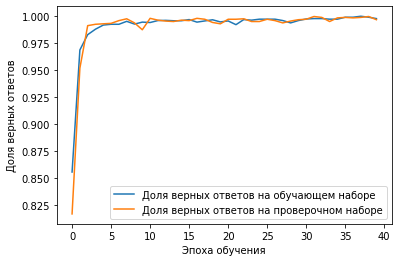

In [ ]:
##########################
# Запустим тренировку нейросети на полученных данных
##########################

# Загружаем модель данными с выбором параметров и сохраним историю обучения(ошибки/точность) для вывода графика
# history = model.fit(x_train, y_train_hot, batch_size=256, epochs=40, verbose=1, validation_data=(x_test, y_test_hot))
history = model.fit(x_train, y_train_hot, batch_size=64, epochs=40, verbose=1, validation_data=(x_test, y_test_hot))

# Построим график, отображающий точность предсказания на обучающей и проверочной выборке
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Проверка

### По шагам

*Разбор данного раздела:* https://youtu.be/yn_SN_a6jFE?t=1531



In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond3.wav' # Получаем имя очередного файла
y,sr = librosa.load(wavfiles) # Загружаем данные модулем librosa
print ('Оригинальный файл:')
ipd.Audio(data=y, rate = sr) # Выводим оригинальный аудиофайл (Команда "Кондиционер" начинается на 12 секунде)

Оригинальный файл:


In [ ]:
mfcc_full, audio_full = wav2mfcc (wavfiles, length=feature_dim_2, step = step_mfcc) # Получаем массив mfcc выбранного файла с именем namefile 

mfcc_full = mfcc_full.reshape(-1, 20, 22, 1) # Решейпим для сверточного слоя
g_pred = model.predict(mfcc_full) # Предиктим с помощью модели model массив mfcc
pred = np.array([np.argmax(i) for i in g_pred]) # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов

3/3 [==============================] - 0s 16ms/step


In [ ]:
print(g_pred.shape)
print(pred.shape)
print(pred[:800])

(72, 4)
(72,)
[1 1 1 1 1 1 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
idxs = np.where(pred == 0) # В массиве pred находим все элементы со значением, равным искомому классу idx_class
idxs = idxs[0] # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность

print (idxs)

[ 6  7  8 15 16 17 18 19 20 21 22 23 24 25 26]


In [ ]:
curr = [] # Временный массив для хранения информации о найденных командах
'''
в массиве idx данные могут быть прдеставлены следующим образом:
[4, 5, 6, 7, 123, 124, 125, 126, 127]
в массив curr мы запишем [4, 123] только стартовые индексы
поскольку очевидно, что 4,5,6,7 и 123,124,125,126,127 представляют единую команду
'''
curr_idx =int (idxs[0]) # Текущий стартовый индекс
summ, length = 0, 0 # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера                                                                        
                                                              #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
for i in range(len(idxs)): # Пробегаем по всему массиву idxs
  summ += g_pred[idxs[i]][0] # Считаем сумму вероятности
  length += 1 # Увеличиваем длинну последовательности
  if i == len(idxs)-1: # Если последний элемент последовательности
    if (length >= 2 and summ / length >= 0.95): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                        # summ / length должно быть больше входного параметра rate
      curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
    break        
  if idxs[i+1]-idxs[i]>1: # Если следующий индекс больше текущего на 1 (означает, что следующий элемент относится уже к другой комманде)
    if (length >= 8 and summ / length >= 0.95): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                        # summ / length должно быть больше входного параметра rate
      curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
    curr_idx = int (idxs[i+1]) # Изменяем текущий стартовый индекс
    summ, length = 0, 0 # Обнуляем summ и length
print (curr)

[]


In [ ]:
np_Audio = []
curr_audio = [] # mfcc отдельной команды
for elem in curr: # Проходим по всему массиву curr
  curr_audio = audio_full[elem[0]]
  if (elem[0] != 0): # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее (чаще всего там будет либо тишина, либо начало команды, которое не разобралось сетью)
    curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))        
  for j in range(1,elem[1]): # Пробегаем цикл от 1 до elem[1] (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
    if (elem[0]+j == len(audio_full)): # Если elem[0] + j равно длинне mfcc, то выходим из цикла
      break    
    curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
  curr_audio = np.array(curr_audio) # Переводим массив в numpy
  np_Audio.append([curr_audio, elem[2]]) # Добавляем данные в выходной массив

print (len(curr_audio))


0


In [ ]:
if (len(np_Audio)==0): # Если длина массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')
for elem in np_Audio: # Пробегам по всем элементам массива out
    print ('Распознана команда: "', classes[0], '" (вероятность - %.2f' % (elem[1]*100), '%)') # Выводим название
    ipd.display(ipd.Audio (elem[0], rate = 22050))

Команда не распознанана!!!


### Функция

*Разбор данного раздела:* https://youtu.be/yn_SN_a6jFE?t=2112



In [ ]:
##########################
# Объявим функцию предсказания команды
##########################
def predict(namefile, model, min_count = 2, rate = 0.9, hole = 1): # функция принимает на вход путь к нужному файлу, и имя обученной модели 
  mfcc_full, audio_full = wav2mfcc (namefile, length=feature_dim_2, step = step_mfcc) # Получаем массив mfcc выбранного файла с именем namefile    

  #mfcc = xScaler.transform(mfcc_full.reshape(-1,1))
  mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)
  g_pred = model.predict(mfcc_full) # Предиктим с помощью модели model массив mfcc
  pred = np.array([np.argmax(i) for i in g_pred]) # Выбираем индекс максимального элемента в каждом g_pred[i]  и создаем numpy-массив pred из этих индексов

  out = [] # Объявляем выходную переменную out (В ней будут храниться преобразованные из mfcc ауидоданные, класс команды и точность, с которой сеть считает эту команду верной)  
  # Ищем команды каждого класса
  for idx_class in range(n_classes-1):
    idxs = np.where(pred == idx_class) # В массиве pred находим все элементы со значением, равным искомому классу idx_class
    idxs = idxs[0] # Размерность полученного маасива в np.where иммет тип (x,). Оставляем только первую размерность
    if (len(idxs) == 0): # Если элементы искомого класса не найдены,
      continue # то переходим к поиску команд следующего класса

    curr = [] # Временный массив для хранения информации о найденных командах
    '''
    в массиве idx данные прдеставлены следующим образом:
    [4, 5, 6, 7, 123, 124, 125, 126, 127]
    в массив curr мы запишем [4, 123] только стартовые индексы
    поскольку очевидно, что 4,5,6,7 и 123,124,125,126,127 представляют единую команду
    '''
    curr_idx =int(idxs[0]) # Текущий стартовый индекс
    summ, length = 0, 0 # summ - хранит сумму вероятностей, с которой сеть отнесла команду к данному классу; length - длинна последовательно идущих элементов для одной команды (для массива curr из примера                                                                        
                                                                  #[4, 123] длина соответствующая первому элементу будет 4, второму - 5 )
    for i in range(len(idxs)): # Пробегаем по всему массиву idxs
      summ += g_pred[idxs[i]][idx_class] # Считаем сумму вероятности
      length += 1 # Увеличиваем длинну последовательности
      if i == len(idxs)-1: # Если последний элемент последовательности
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length

        break  
      if idxs[i+1]-idxs[i]>hole: # Если следующий индекс больше текущего на hole (означает, что следующий элемент относится уже к другой комманде)
        if (length >= min_count and summ / length >= rate): # Проверяем на условия разбора: длинна последовательности должна быть больше входного параметра min_count
                                                            # summ / length должно быть больше входного параметра rate
          print(length)
          curr.append([curr_idx, length, summ / length]) # Если условия выполняются, то добавляем в маасив стартовый индекс найденной команды, длинну последовательности и summ / length
        curr_idx = int (idxs[i+1]) # Изменяем текущий стартовый индекс
        summ, length = 0, 0 # Обнуляем summ и length
    curr_audio = [] # mfcc отдельной команды
    for elem in curr: # Проходим по всему массиву curr
      #if (elem[0] != 0): # Если это не самый первый элемент исходных данных, то возьмем на одну mfcc левее (чаще всего там будет либо тишина, либо начало команды, которое не разобралось сетью)
      #  curr_audio = np.concatenate((audio_full[elem[0] - 1], audio_full[elem[0]][:, -step_mfcc:,:]), axis = 0)
      #else:
      curr_audio = audio_full[elem[0]] # Если это стартовый элемент исходных данных, то берем самую первую mfcc
      for j in range(1,elem[1]): # Пробегаем цикл от 1 до elem[1]+1 (где elem[1] хранит длинну последовательности элементов, отнесенных к одной команде)
        if (elem[0]+j == len(audio_full)): # Если elem[0] + j равно длинне mfcc, то выходим из цикла
          break
        #curr_audio = np.concatenate((curr_audio, audio_full[elem[0] + j][:,-step_mfcc:,:]), axis = 1) # Создаем единий mfcc, использую concatenate для добавления к текущему значению срез динной step_mfcc из следующего элемента
        curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
      curr_audio = np.array(curr_audio) # Переводим массив в numpy
      #curr_mfcc = curr_mfcc.reshape (curr_mfcc.shape[0], curr_mfcc.shape[1]) # Убираем третью размерность
      #curr_mfcc_unscaled= xScaler.inverse_transform(curr_mfcc)
      #recon = librosa.feature.inverse.mfcc_to_audio(curr_mfcc_unscaled) # Получаем ауди из mfcc
      out.append([curr_audio, idx_class, elem[2]]) # Добавляем данные в выходной массив
  return out, pred, g_pred # Возращаем массив с данными, массив с классами команд, массив с softmax данными

In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond14.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.8, hole = 2)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))


1/1 [==============================] - 0s 49ms/step
Распознана команда: " КОНДИЦИОНЕР " (вероятность - 98.52 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_cond7.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 6, rate = 0.9, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))


1/1 [==============================] - 0s 36ms/step
Распознана команда: " КОНДИЦИОНЕР " (вероятность - 99.99 %)


In [ ]:
wavfiles =  DATA_PATH_TEST + 'text_with_televizor6.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 10, rate = 0.98, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

1/1 [==============================] - 0s 22ms/step
Команда не распознанана!!!


In [ ]:
# Уменьшим параметр rate до 0.75
wavfiles =  DATA_PATH_TEST + 'text_with_svet'+str(12)+'.wav' # Получаем имя очередного файла
out, pred, _ = predict(wavfiles, model=model, min_count = 2, rate = 0.8, hole = 1)  # Вызываем predict для очередного файла  
if (len(out)==0): # Если длинна массива равна 0, то команда не распознана
  print('Команда не распознанана!!!')
for elem in out: # Пробегам по всем элементам массива out
  print ('Распознана команда: "', classes[elem[1]], '" (вероятность - %.2f' % (elem[2]*100), '%)') # Выводим название
  ipd.display(ipd.Audio (elem[0], rate = 22050))

1/1 [==============================] - 0s 37ms/step
Распознана команда: " СВЕТ " (вероятность - 99.95 %)


# Вывод

Приняты меры по балансировке классов в наборе данных, оставлено по 1970 примеров каждого класса. Данное значение получено из статистики , а именно из результата предварительного запуска функции save_data_to_array(length=feature_dim_2). Также были изменены гиперпараметры обучения нейронной сети: batch_size = 64, можно еще уменьшить, так как кол-во признаков существенно сокращено. Неизменными оставлены гиперпараметры слоев нейросети, можно еще с этим поработать, чтобы 